<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/10_Proyecto_Final/Opcion_2/Borrador2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
!pip install xgboost
from xgboost import XGBClassifier

# **Dataset**

El dataset a utilizar en este proyecto consiste en una colección de 10.000 observaciones del espacio tomadas por la Sloan Digital Sky Survey. Cada observación está descrita por 17 características y una variables objetivo la cual identifica la observación como una estrella, una galaxia o un quásar.

Las distintas características son las siguientes:

1. **objid:** Identador único para cada objeto estelar.
2. **ra:** Ascensión Recta (RA), coordenada de longitud en el cielo.
3. **dec:** Declinación (Dec), coordenada de latitud en el cielo.
4. **u, g, r, i y z:** Magnitudes fotométricas en cinco bandas del sistema SDSS (utravioleta, verde, rojo, infrarrojo cercano e infrarrojo). Estas representan el brillo del objeto en distintos rangos de longitud de onda.
5. **run:** Número de ejecución (scan run) durante la captación de la imagen.
6. **rerun:** Número de re-ejecución del procesamiento de la imagen.
7. **camcol:** Columna de cámara; indica la fila del CCD utilizada en el escaneo.
8. **field:** Identificador del campo (región del cielo) en el escaneo.
9. **specobjid:** ID único del objeto en el catálogo espectroscópico.
10. **redshift:** Corrimiento al rojo (z), indicador de distancia y velocidad del objeto respecto a la Tierra.
11. **plate:** ID de placa espectroscópica usada en la observación.
12. **mjd:** Modified Julian Date, fecha de observación en formato científico Julina.
13. **fiberid:** ID de fibre óptica que capturó la luz del objeto para espectroscopía.
14. **class:** Variable objetivo que indica la clase astronómica del objeto (galaxia, estrella o quásar).

Notemos que hay varias características que no aportan información al momento de realizar el análisis de los datos para una próxima clasificación, por lo que se procederá a separar las variables con mayor importancia para la realización del proyecto.

Lo anterior refleja la importancia de entender el contexto de las variables, para que estas no generen ruido innecesario al momento del modelamiento o produzcan predicciones erróneas.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Kevin2558/Data_Science_Borrador/main/10_Proyecto_Final/Opcion_2/SDSS_Data.csv")
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


# **Análisis Exploratorio de Datos (EDA)**

Como análizamos al comienzo, eliminaremos del dataset las variables que no aportan en este análisis y nos centraremos en las que si aportan información valiosa.

In [3]:
df = df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid'], axis=1)
df.head()

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


Partiremos realizando una visualización espacial de los objetos estelares a través de las variables ra y dec, las cuales representan las coordenadas en el cielo de estas.

Esto para tener un primer vistazo del dataset, comprender si existen cúmulos de galaxias o sectores con alta densidad de estrellas y analizar visualmente la frecuencia de cada objeto y determinar la necesidad de un balanceo de clases.

En el caso de que espacialmente representen agrupaciones las utilizaremos para el modelamiento y predicción. En el caso de que las agrupaciones estén en su mayoria acopladas, la usaremos únicamente como una primera visualización de los datos.

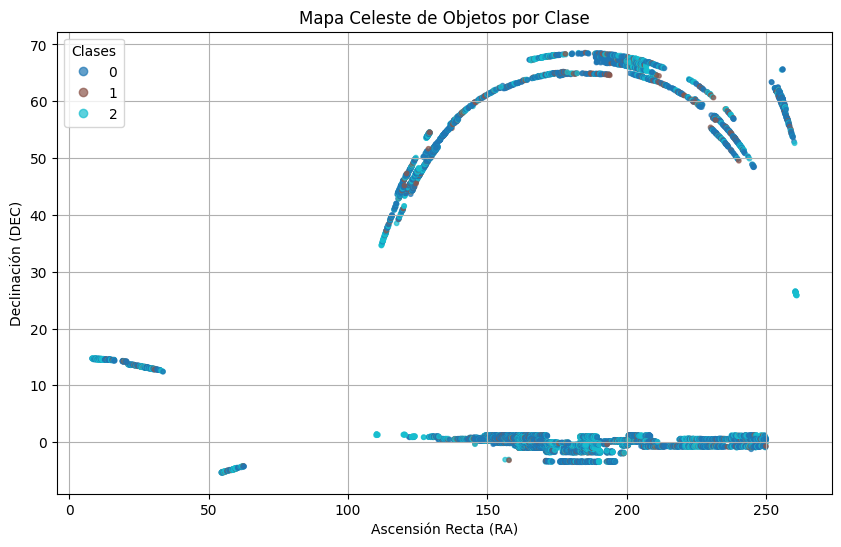

In [4]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['ra'], df['dec'], c=df['class'].astype('category').cat.codes, cmap='tab10', alpha=0.7, s=10)
plt.legend(*scatter.legend_elements(),title="Clases")
plt.xlabel('Ascensión Recta (RA)')
plt.ylabel('Declinación (DEC)')
plt.title('Mapa Celeste de Objetos por Clase')
plt.grid(True)
plt.show()

Como podemos notar, los elementos de la clase 0 (galaxias) son los que se ven más representados, luego le siguen los de la clase 2 (estrellas) y por último los objetos de la clase 1 (quásares) se ven muy poco representados.

Esto evidencia una necesidad de balanceo de clases para que los modelos aprendan significativamente como identificar cada clase y no predomine la que posee más casos.

Como dijimos antes, los datos espacialmente no representan notoriamente agrupaciones, por lo que procederemos a eliminarlas.

Así, el proyecto de clasificación se centrará en analizar los objetos estelares a través de las variables u, g, r, i, z y redshift.

In [5]:
df = df.drop(['ra', 'dec'], axis=1)
df.head()

,u,g,r,i,z,class,redshift
0,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


Veamos si el dataset presenta valores nulos. De llegar a tenerlos se procederá a analizar la acción sobre ellos.

In [6]:
df.isnull().sum()

,0
u,0
g,0
r,0
i,0
z,0
class,0
redshift,0


Visualicemos las estadísticas descriptivas básicas del dataset para evaluar, a primera vista, que columnas pueden poseer outliers.

In [7]:
df.describe()

,u,g,r,i,z,redshift
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.619355,17.371931,16.840963,16.583579,16.422833,0.143726
std,0.828656,0.945457,1.067764,1.141805,1.203188,0.388774
min,12.988970,12.799550,12.431600,11.947210,11.610410,-0.004136
25%,18.178035,16.815100,16.173333,15.853705,15.618285,0.000081
50%,18.853095,17.495135,16.858770,16.554985,16.389945,0.042591
75%,19.259232,18.010145,17.512675,17.258550,17.141447,0.092579
max,19.599900,19.918970,24.802040,28.179630,22.833060,5.353854


Notemos que la mayoria de las variables se mueven en un rango aceptable, por lo que el dataset puede no presentar outliers.

Además, notemos que todas las variables de magnitudes fotométricas poseen varianzas y medias similares.

Para redshift, podemos notar que entre el valor mínimo y el valor máximo hay una diferencia de dimensionalidad notable (de 10^3 aprox.) pero esta variable nos indica distancia y velocidad con respecto a la Tierra por lo que mantenerla en esta dimensionalidad nos ayudará a encontrar patrones en las clases.

Transformemos la variables objetivo 'class' a variable categórica para poder utilizarla en los modelos.

In [8]:
df['class'] = df['class'].astype('category').cat.codes
df['class'].head()

,class
0,2
1,2
2,0
3,2
4,2


Separemos los datos entre características y variables objetivo.


In [9]:
X = df.drop('class', axis=1)
y = df['class']

Realicemos histogramas por variables para ver como se distribuye el dataset por variable.

Además lo separaremos por clases para ver si el comportamiento de cada variable se mantiene en las clases o hay clases que presentan comportamientos diferentes.

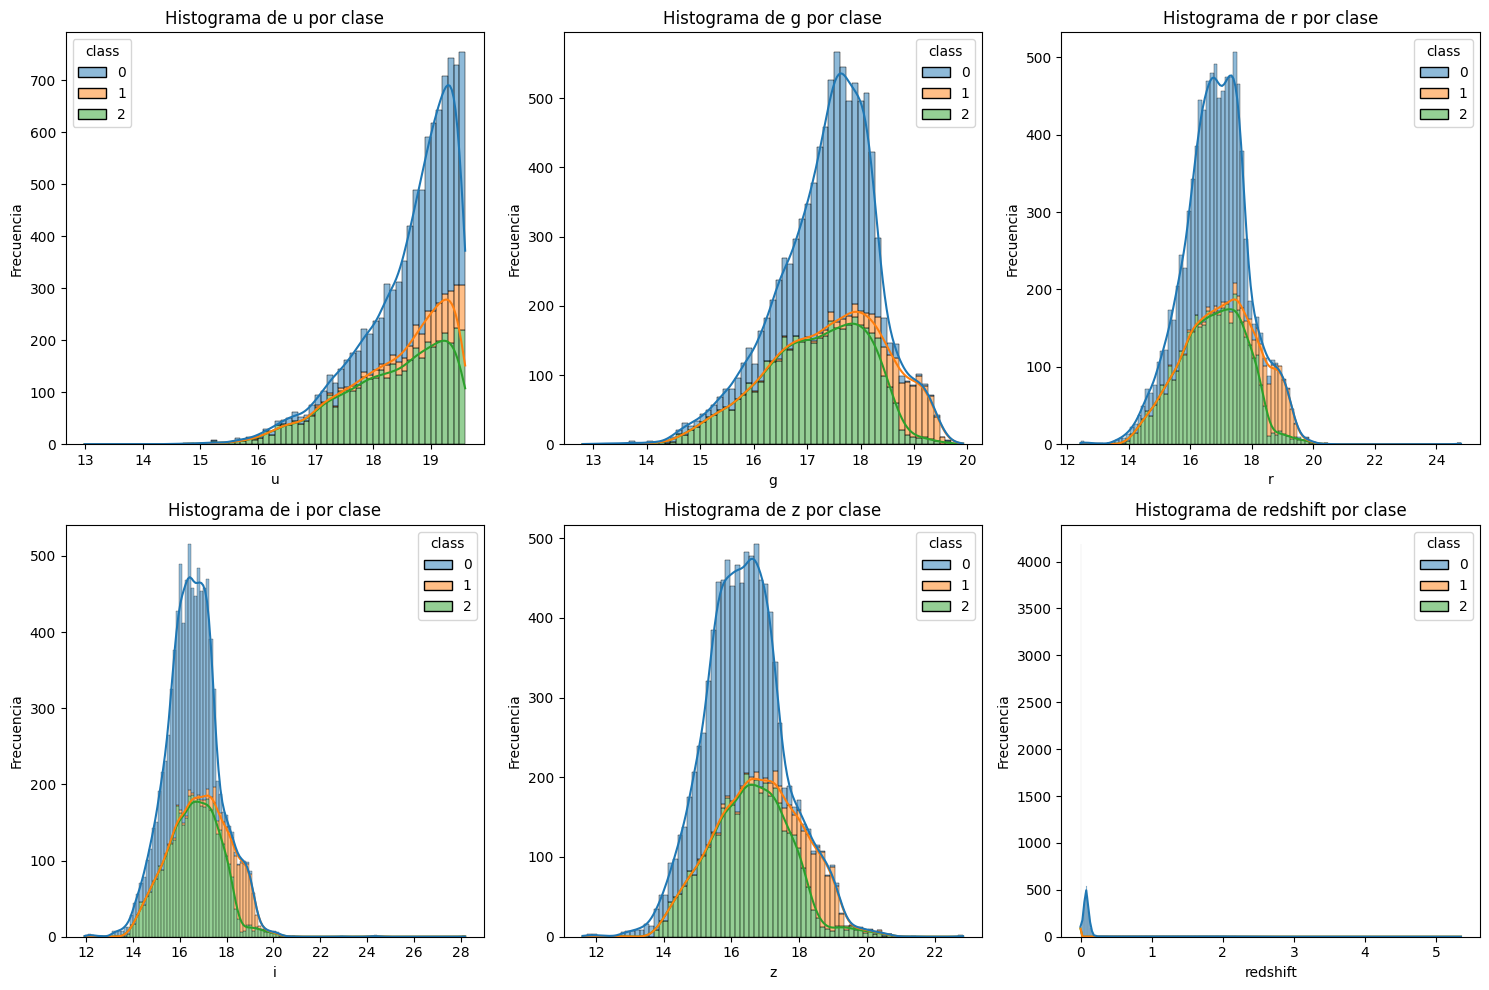

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.histplot(data=df, x=feature, hue='class', multiple='stack', kde=True, palette='tab10',ax=axes[i])
    axes[i].set_title(f'Histograma de {feature} por clase')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

Como podemos notar las 5 magnitudes fotométricas se comportan como una variable normal y este comportamiento se mantiene en todas las clases.

También se puede evidenciar el desbalance de clases, por lo que más adelante lo trataermos.

Ahora, visualicemos el comportamiento de los datos outliers por magnitud fotométrica y la cantidad total de ellos.

Observemos gráficos boxplots por clases comprobar la primera idea que tuvimos repecto a los datos outliers.

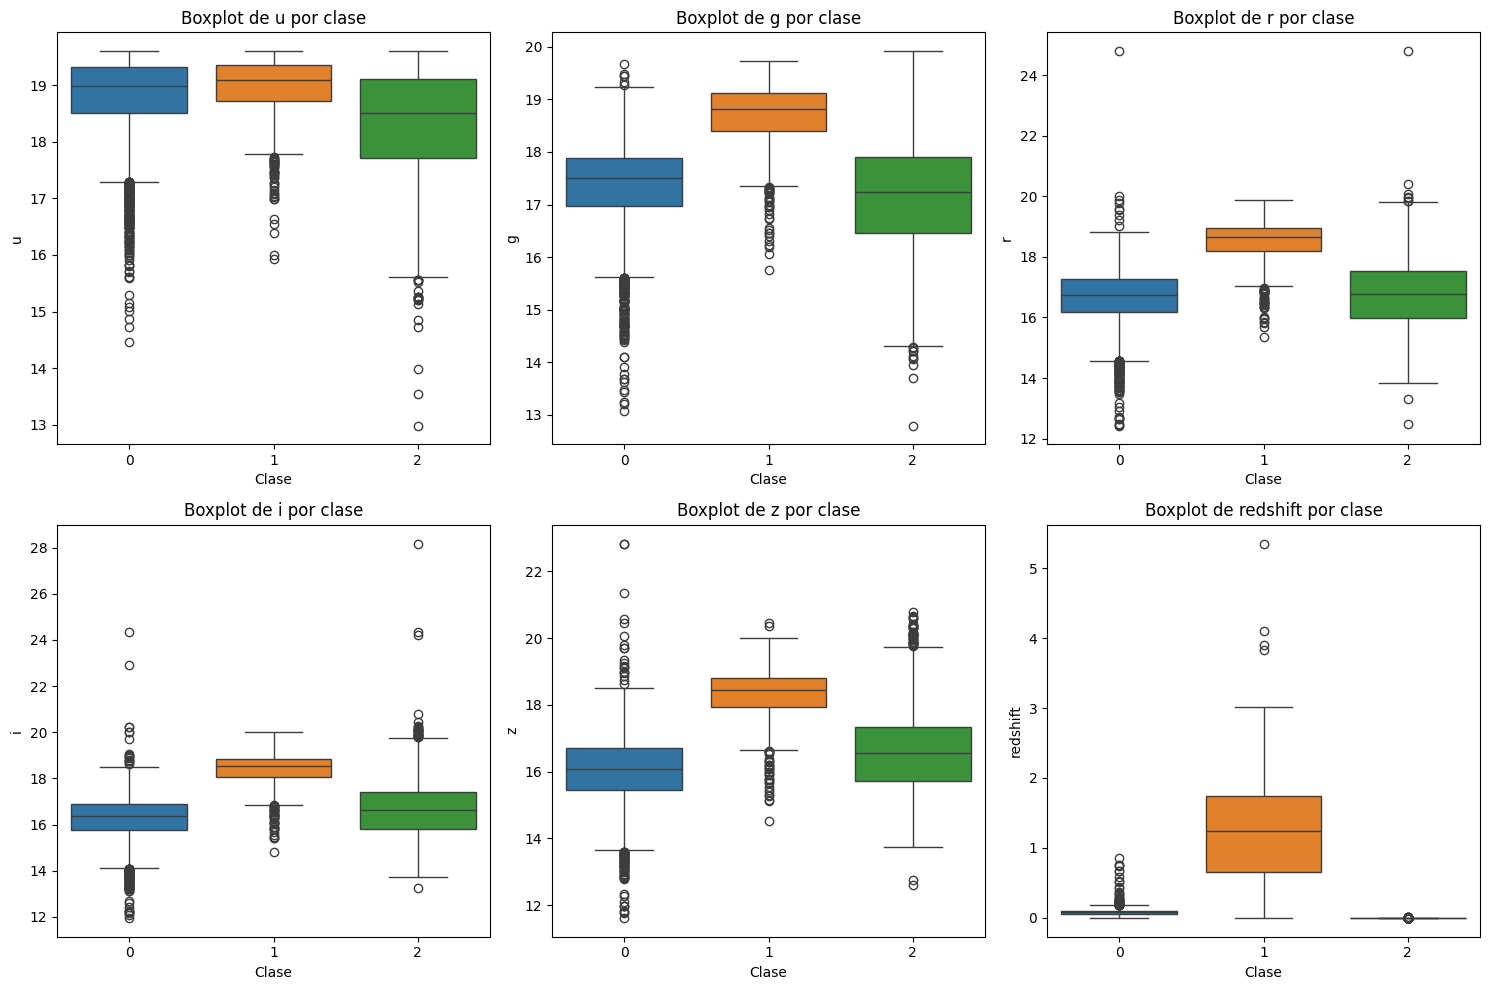

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.boxplot(x='class', y=feature, data=df, hue='class', palette='tab10', legend=False, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature} por clase')
    axes[i].set_xlabel('Clase')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

Como se puede observar, se evidencia una cantidad notable de outliers en todas las variables y en todas las clases.

Hay casos (como la clase 2 en la variable fotométrica r) donde le número de outliers es despreciable, pero como el fenómeno se mantiene en general se considerará el tratamiento de ellos.

Calculemos el número de outliers según IQR y según z-score.

In [12]:
from scipy import stats

outliers = 0
for feature in X.columns:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers_iqr = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
  outliers += len(outliers_iqr)

print(f'Número de outliers según IQR: {outliers}')
print(f'Porcentaje de outlier según IQR: {outliers/10000*100:.1f}%')

print('')
z_scores = np.abs(stats.zscore(X))

outliers = (z_scores > 3).any(axis=1)
print(f"Número de outliers según z-score: {outliers.sum()}")
print(f'Porcentaje de outlier según z-score: {outliers.sum()/10000*100:.1f}%')

Número de outliers según IQR: 1575
Porcentaje de outlier según IQR: 15.8%

Número de outliers según z-score: 532
Porcentaje de outlier según z-score: 5.3%


Y como se evidenció anteriormente, hay una gran presencia de datos outliers por lo que se tendrá en cuenta cuando se comience el tratamiento de los datos para el modelado.

Visualicemos la matriz de correlación para ver cuales son las variables que están altamente correlacionadas.

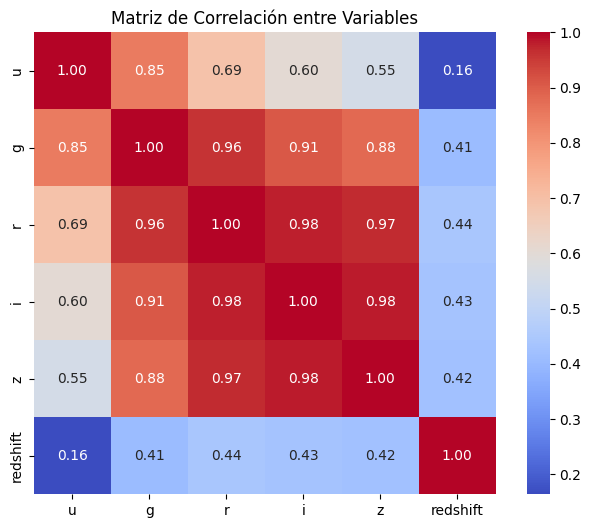

In [13]:
plt.figure(figsize=(8, 6))
corr = X.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Matriz de Correlación entre Variables')
plt.show()

Como podemos notar, las variables de magnitudes fotométricas presentar alta correlación entre todas (0.88 - 0.98) lo cual es esperable debido a que estas miden el nivel de brillo de los objetos en bandas de longitud de ondas cercanas.

Como observación, se puede notar que redshift tiene una correlación moderada con las variables, lo cual argumenta nuestra primer decisión de mantenerla para el análisis ya que esta variable entregará información adicional y de valor al momento de la toma de decisiones dentro del entrenamiento y de las predicciones.

Veamos si el dataset presenta filas duplicadas para la eliminación de ellas (evitar redundancia).

In [14]:
duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 0


# **Visualización**

Realizaremos una reducción de dimensionalidad para la visualización 2D de los datos a través de t-SNE.

Escalaremos con RobustScaler debido a que en el cálculo de outliers, eran 1.000 de 10.000 datos por lo que pueden obstruir en nuestro análisis.

In [16]:
X_scaled = RobustScaler().fit_transform(X)

tsne = TSNE(n_components=2,
            perplexity=48,
            learning_rate=200,
            random_state=42)

X_tsne = tsne.fit_transform(X_scaled)

Visualización.

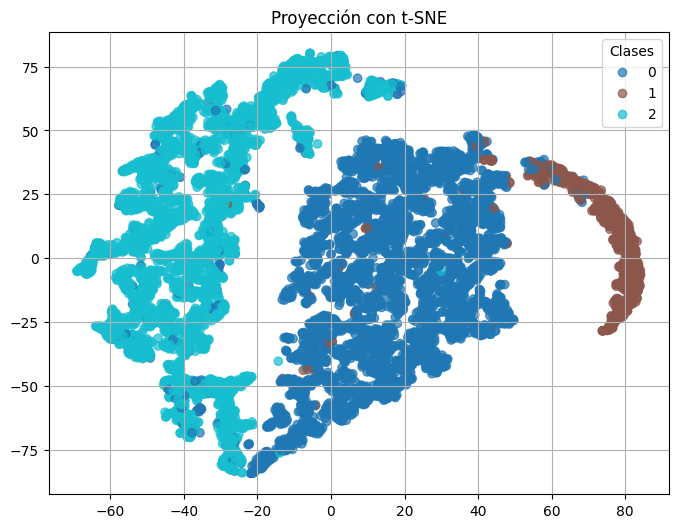

In [17]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(),title="Clases")
plt.title("Proyección con t-SNE")
plt.grid(True)
plt.show()

Como podemos observar las clases tienen un claro comportamiento separable. Esto representará ventajas a la hora de la elección de modelos ya que esto es fundamental para el buen funcionamiento de alguno de ellos.

# **Balanceo de clases**

Ahora, comencemos con el tratamiento del evidente desbalanceo de clases.

Realicemos un gráfico de frecuencias por clases.

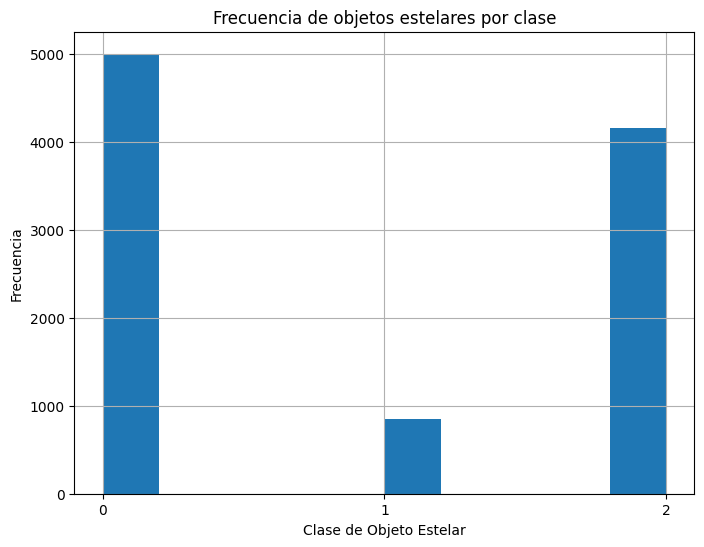

In [24]:
plt.figure(figsize=(8, 6))
y.hist()
plt.xticks(sorted(y.unique()), y.astype('category').cat.categories)
plt.title('Frecuencia de objetos estelares por clase')
plt.xlabel('Clase de Objeto Estelar')
plt.ylabel('Frecuencia')
plt.show()

Esto termina de evidenciar el notable desbalanceo de clases, por lo que se procederá a balancearlas.

Clases balanceadas a través de SMOTE.

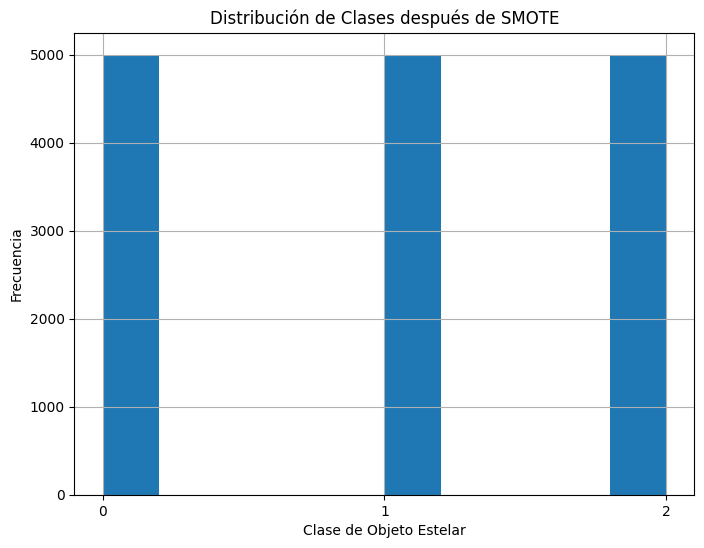

In [25]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

plt.figure(figsize=(8, 6))
y_res.hist()
plt.xticks(sorted(y_res.unique()), y_res.astype('category').cat.categories)
plt.title('Distribución de Clases después de SMOTE')
plt.xlabel('Clase de Objeto Estelar')
plt.ylabel('Frecuencia')
plt.show()

Realizado el balanceo de clases pertinente, procedamos al modelamiento y predicción.

# **Modelamiento**

Hagamos la división de los datos entre entrenamiento y validación en una proporción 80/20.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

Tomando el cuenta el EDA realizado anteriormente, los modelos a utilizar son:

* K-NN
* SVC (kernel RBF)
* Random Forest
* XGBoost
* MLP (una capa de 100 neuronas)
* MLP (tres capas de 100, 50 y 25 neuronas)

Las justificaciones de utilización de cada uno de estos modelos se explicitarán en cada apartado.

## K-NN

Lo utilizaremos como modelo simple, por rápidez y por ser no paramétrico.

In [ ]:
knn = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3,
                                 p=2,
                                 metric='minkowski'
    ))
])

Entrenamiento.

In [ ]:
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

## SVC (kernel RBF)

Lo utilizaremos debido a que como vimos en la visualización con t-SNE están notablemente separadas, por lo que este modelo podria funcionar bien.

In [ ]:
svc = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(random_state=42,
                C=0.1,
                kernel='rbf',
                gamma='scale'
    ))
])

Entrenamiento.

In [ ]:
svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('svc', SVC(C=0.1, random_state=42))])

## Random Forest

Lo utilizaremos como primer modelo bien robusto, el cual nos puede dar buenas predicciones, también por su buena interpretabilidad.


In [ ]:
rf = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=None
                                  ))
])

Entrenamiento.

In [ ]:
rf.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

## XGBoost

Lo utilizaremos debido a su posible mejoría con respecto a Random Forest además de ser un modelo generalmente utilizado por su buen rendimiento.

In [ ]:
xgb = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100,
                          learning_rate=1.0,
                          max_depth=3,
                          random_state=42
                          ))
])

Entrenamiento.

In [ ]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## MLP

Lo utilizaremos por ser una opción muy viable debido a su potencia en clasificación no lineal. Utilizaremos 2 redes, una más simple que la otra.

In [ ]:
mlp_100 = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100,),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          ))
])

mlp_1005025 = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100, 50, 25),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          ))
])

Entrenamiento.

In [ ]:
mlp_100.fit(X_train, y_train)
mlp_1005025.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000,
                               random_state=42))])

# **Predicción y Evaluación**

Por último, realicemos la predicción del mejor modelo para MLP y visualicemos las métricas que evalúan su predicción.

In [ ]:
y_pred = []
model_names = ["K-NN", "SVC (kernel RBF)", "Random Forest", "XGBoost", "MLP (100)", "MLP (100, 50, 25)"]
models = [knn, svc, rf, xgb, mlp_100, mlp_1005025]

for i, model in enumerate(models):
  y_pred.append(model.predict(X_test))
  print("Reporte del modelo", model_names[i])
  print('')
  print(classification_report(y_test, y_pred[-1]))
  print("-" * 50)

Reporte del modelo K-NN

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.91      0.95      0.93       170
           2       0.94      0.97      0.95       830

    accuracy                           0.95      2000
   macro avg       0.94      0.95      0.94      2000
weighted avg       0.95      0.95      0.95      2000

--------------------------------------------------
Reporte del modelo SVC (kernel RBF)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1000
           1       0.98      0.94      0.96       170
           2       0.95      0.98      0.96       830

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

--------------------------------------------------
Reporte del modelo Random Forest

              precision    recall  f1-sc


------------------------------------------------
Matriz de confusión del modelo K-NN
------------------------------------------------



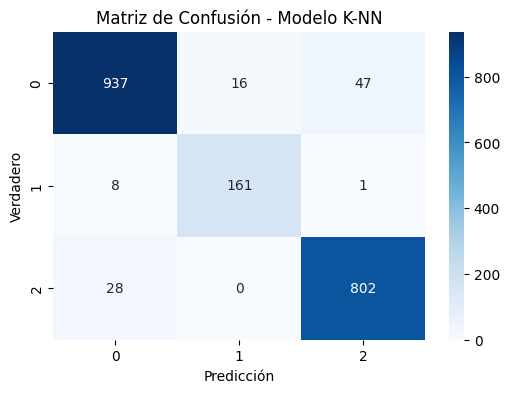


------------------------------------------------
Matriz de confusión del modelo SVC (kernel RBF)
------------------------------------------------



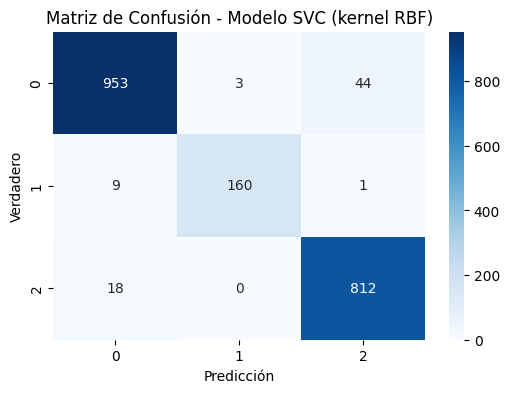


------------------------------------------------
Matriz de confusión del modelo Random Forest
------------------------------------------------



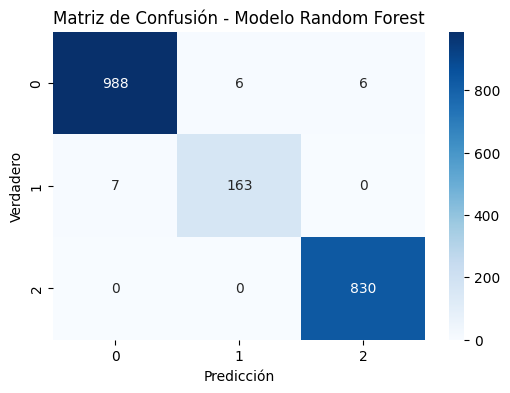


------------------------------------------------
Matriz de confusión del modelo XGBoost
------------------------------------------------



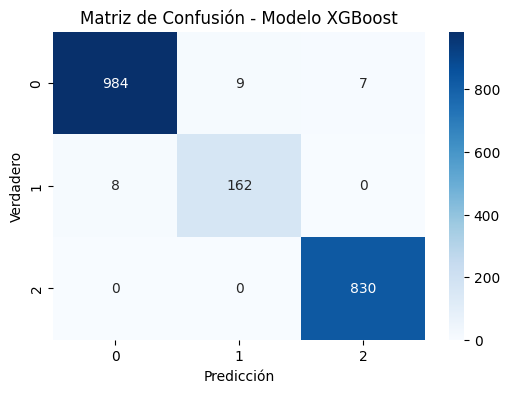


------------------------------------------------
Matriz de confusión del modelo MLP (100)
------------------------------------------------



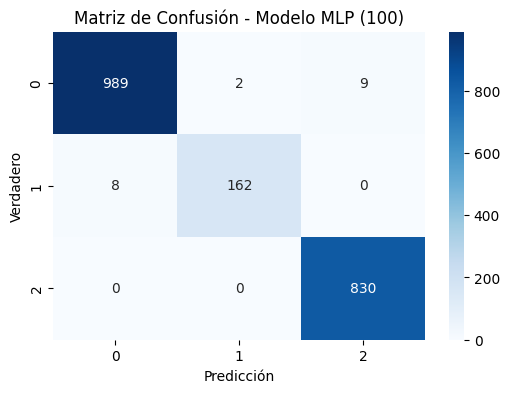


------------------------------------------------
Matriz de confusión del modelo MLP (100, 50, 25)
------------------------------------------------



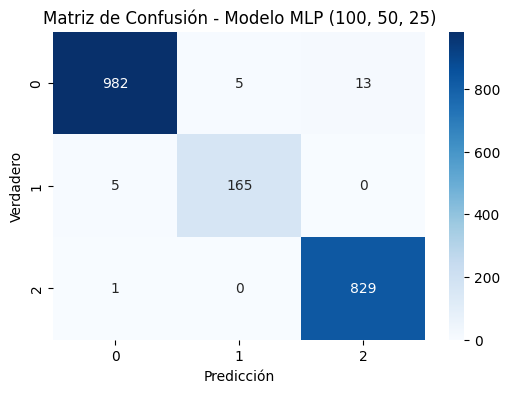

In [ ]:
for i, model in enumerate(models):
  print('')
  print("-" * 48)
  print("Matriz de confusión del modelo", model_names[i])
  print("-" * 48)
  print('')
  conf_matrix = confusion_matrix(y_test, y_pred[i])
  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title("Matriz de Confusión - Modelo " + model_names[i])
  plt.xlabel("Predicción")
  plt.ylabel("Verdadero")
  plt.show()